<a href="https://colab.research.google.com/github/hyphen-git/Python/blob/main/Copy_of_notebook0e5c68b873.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ads16-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F659%2F1257%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240131%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240131T004219Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4a970d34cbb0baf6f0210d68beb52e2556829695e20e35d73ba4ad1d0f3b98202a2d87006d3de6921dd2ad5847fb051fd29f127e513e6515a2d2dedc4cb6bb20c1d9c22aec12ea88c56c260b570bad1fa7b974559573ebb62fac67ec4cec1656f411513d0ffedad9e64447b268e854552f67f8af2eefe29f2c240b2f3e271a6a65ad54b4d2a5f66543a0c0f19263af94ab12bd532a35531fbc92de9e1a41dfaecfc3c1bce8e6515c4d80a91395d7600f50fac956ea2e9d49e01eec476f0344c0801190d52bec7980f7f34aded796f3d6b982e02c16ff2653db31063d293214f9ddf94198246a79a47d7fe2940eb3d0a8a17ca1b5a8c4ba5995ee6151c33be55f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1581233701 bytes downloaded
Downloaded and uncompressed: ads16-dataset
Data source import complete.


In [ ]:
# prompt: how to how to Resize Images: Ensure all images have the same dimensions. and save all the images in another folder

from PIL import Image
import os

source_folder = '/content/images'
target_folder = '/content/resized_images'

target_size = (224, 224)  # Desired image size (width, height)

# Create the target folder if it doesn't exist
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# Iterate through all files in the source folder
for filename in os.listdir(source_folder):
    # Check if the file is an image
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        # Open the image
        image_path = os.path.join(source_folder, filename)
        image = Image.open(image_path)

        # Resize the image
        resized_image = image.resize(target_size)

        # Save the resized image to the target folder
        new_path = os.path.join(target_folder, filename)
        resized_image.save(new_path)

print('All images resized and saved successfully.')

All images resized and saved successfully.


In [ ]:
# prompt: how to perform normalization on images present in resizedimages folder

import os
from PIL import Image

folder_path = '/content/resized_images'
files = os.listdir(folder_path)

for filename in files:
  image_path = os.path.join(folder_path, filename)
  image = Image.open(image_path)
  image = image.convert('L')  # Convert to grayscale
  normalized_image = image.point(lambda x: x / 255.0)  # Normalize pixel values
  normalized_image.save(image_path)  # Save the normalized image

print('Normalization complete.')


Normalization complete.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import efficientnet.tfkeras as efn
import glob
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
data_dir = '/content/resized_images'

# Get the list of image paths
image_paths = glob.glob(os.path.join(data_dir, '*.jpg'))

# Shuffle the image paths
np.random.shuffle(image_paths)

# Load labels based on the assumption that 'ad' images are labeled as 1 and 'non_ad' as 0
labels = [1 if 'ad' in os.path.basename(path) else 0 for path in image_paths]

# Split the data into training and validation sets using sklearn
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)

# Image data generator with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Image data generator for validation (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

# Batch size
batch_size = 32

# Create generators for training and validation
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_train, 'label': y_train}),
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='raw',
    shuffle=True,
)

validation_generator = val_datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_val, 'label': y_val}),
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False,
)

# Print the number of samples in training and validation sets
print("Number of training samples:", len(train_generator))
print("Number of validation samples:", len(validation_generator))

# Get the number of classes (categories)
num_classes = 1

# Create the model
model = tf.keras.Sequential([
    efn.EfficientNetB0(input_shape=(224, 224, 3), include_top=False),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Save the model
# Save the model in native Keras format
model.save('ad_classification_model_keras')


Found 8 validated image filenames.
Found 2 validated image filenames.
Number of training samples: 1
Number of validation samples: 1
Epoch 1/20
1/1 [==============================] - 26s 26s/step - loss: 0.7948 - accuracy: 0.2500 - val_loss: 0.5985 - val_accuracy: 1.0000
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 0.5939 - accuracy: 0.7500 - val_loss: 0.5737 - val_accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 0.6193 - accuracy: 0.7500 - val_loss: 0.5857 - val_accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 1.0215 - accuracy: 0.5000 - val_loss: 0.5898 - val_accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 3s 3s/step - loss: 0.8560 - accuracy: 0.7500 - val_loss: 0.5539 - val_accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 0.5929 - accuracy: 0.7500 - val_loss: 0.5200 - val_accuracy: 1.0000
Epoch 7/20
1/1 [============================

In [ ]:
# ... (Previous code for training the model)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Save the model
model.save('ad_classification_model_keras')

# Predict on the validation set
predictions = model.predict(validation_generator)

# Define a threshold (e.g., 0.5)
threshold = 0.5

# Convert probabilities to binary predictions
binary_predictions = (predictions > threshold).astype(int)

# Display the binary predictions
print("Binary Predictions:", binary_predictions.flatten())

# Create a DataFrame with image paths, true labels, and binary predictions
result_df = pd.DataFrame({
    'Image Path': X_val,
    'True Label': y_val,
    'Predicted Label': binary_predictions.flatten()
})

# Display the DataFrame
print(result_df)


1/1 [==============================] - 0s 186ms/step - loss: 0.5200 - accuracy: 1.0000
Loss: 0.5199946165084839, Accuracy: 1.0


1/1 [==============================] - 2s 2s/step
Binary Predictions: [0 0]
                                          Image Path  True Label  \
0  /content/resized_images/ravi-sharma-3Qq5k5P982...           0   
1  /content/resized_images/mitchell-orr-koRDP2yAQ...           0   

   Predicted Label  
0                0  
1                0  


1/1 [==============================] - 0s 387ms/step - loss: 0.5200 - accuracy: 1.0000
Loss: 0.5199946165084839, Accuracy: 1.0
1/1 [==============================] - 0s 224ms/step


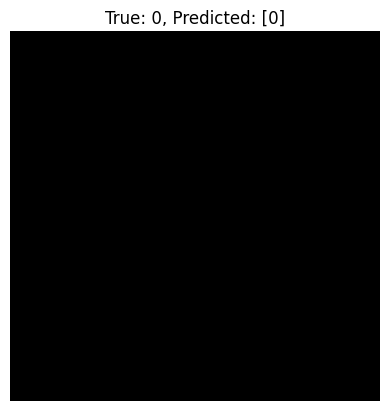

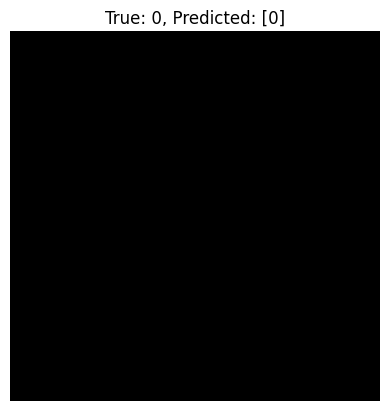

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# ... (Previous code for training the model)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Save the model
model.save('ad_classification_model_keras')

# Predict on the validation set
predictions = model.predict(validation_generator)

# Define a threshold (e.g., 0.5)
threshold = 0.5

# Convert probabilities to binary predictions
binary_predictions = (predictions > threshold).astype(int)

# Display the predictions along with the images
for i in range(len(X_val)):
    img_path = X_val[i]
    true_label = y_val[i]
    predicted_label = binary_predictions[i]

    # Load and display the image
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')

    # Display true and predicted labels
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.show()


1/1 [==============================] - 0s 330ms/step - loss: 0.5200 - accuracy: 1.0000
Loss: 0.5199946165084839, Accuracy: 1.0
1/1 [==============================] - 0s 236ms/step


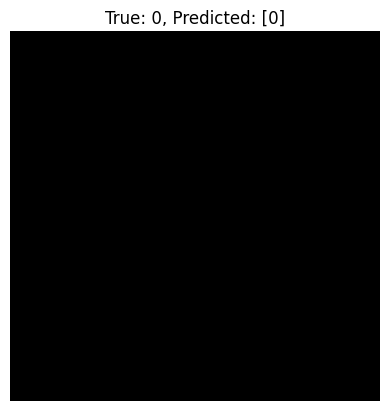

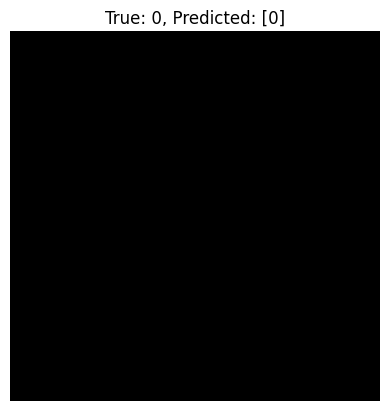

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# ... (Previous code for training the model)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Save the model
model.save('ad_classification_model_keras')

# Predict on the validation set
predictions = model.predict(validation_generator)

# Define a threshold (e.g., 0.5)
threshold = 0.5

# Convert probabilities to binary predictions
binary_predictions = (predictions > threshold).astype(int)

# Display some images along with their true and predicted labels
num_display = min(5, len(X_val))  # Display at most 5 images

for i in range(num_display):
    img_path = X_val[i]
    true_label = y_val[i]
    predicted_label = binary_predictions[i]

    # Load and display the image
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')

    # Display true and predicted labels
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.show()


1/1 [==============================] - 0s 145ms/step - loss: 0.5200 - accuracy: 1.0000
Loss: 0.5199946165084839, Accuracy: 1.0
1/1 [==============================] - 0s 219ms/step


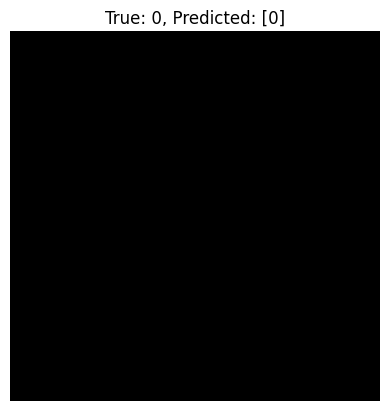

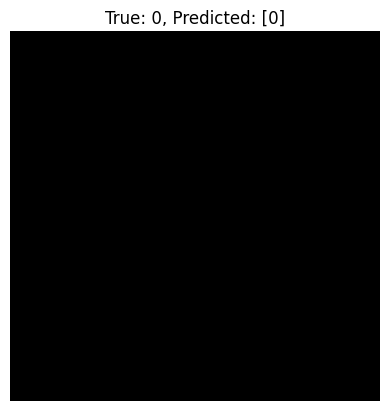

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# ... (Previous code for training the model)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Save the model
model.save('ad_classification_model_keras')

# Predict on the validation set
predictions = model.predict(validation_generator)

# Define a threshold (e.g., 0.5)
threshold = 0.5

# Convert probabilities to binary predictions
binary_predictions = (predictions > threshold).astype(int)

# Display some images along with their true and predicted labels
num_display = min(5, len(X_val))  # Display at most 5 images

for i in range(num_display):
    img_path = X_val[i]
    true_label = y_val[i]
    predicted_label = binary_predictions[i]

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values

    # Display the preprocessed image
    plt.imshow(img_array[0])
    plt.axis('off')

    # Display true and predicted labels
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.show()




In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Path to the folder containing resized images
folder_path = '/content/resized_images'

# Function to predict whether an image is an ad or non-ad
def predict_image_category(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    decoded_predictions = decode_predictions(predictions)

    # Check if the prediction contains keywords related to ads (you may need to customize this based on the model's predictions)
    ad_keywords = ["advertisement", "poster", "billboard", "banner"]
    for _, label, _ in decoded_predictions[0]:
        if any(keyword in label.lower() for keyword in ad_keywords):
            return "Ad"

    return "Non-Ad"

# Iterate through all images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Assuming images are in JPG or PNG format
        image_path = os.path.join(folder_path, filename)
        category = predict_image_category(image_path)
        print(f"{filename}: {category}")


35363/35363 [==============================] - 0s 0us/step
nasa-hubble-space-telescope-waDAyTyGqXM-unsplash.jpg: Non-Ad
1/1 [==============================] - 1s 530ms/step
11.png: Non-Ad
1/1 [==============================] - 1s 526ms/step
mieke-campbell-Co3Qv42iieM-unsplash.jpg: Non-Ad
1/1 [==============================] - 1s 533ms/step
15.png: Non-Ad
1/1 [==============================] - 1s 521ms/step
4.png: Non-Ad
1/1 [==============================] - 1s 533ms/step
uran-wang-0igggrtWCKg-unsplash.jpg: Non-Ad
1/1 [==============================] - 1s 511ms/step
8.png: Non-Ad
1/1 [==============================] - 1s 526ms/step
16.png: Non-Ad
1/1 [==============================] - 1s 533ms/step
9.png: Non-Ad
1/1 [==============================] - 1s 531ms/step
2.png: Non-Ad
1/1 [==============================] - 1s 759ms/step
mitchell-orr-koRDP2yAQNk-unsplash.jpg: Non-Ad
1/1 [==============================] - 1s 718ms/step
7.png: Non-Ad
1/1 [==============================] - 1s 618

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

def predict_image_category(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    decoded_predictions = decode_predictions(predictions)

    # Display the top prediction
    print(f"Top Prediction: {decoded_predictions[0][0][1]} ({decoded_predictions[0][0][2]:.2%})")

    # Define keywords for ad classification
    ad_keywords = ["advertisement", "poster", "billboard", "banner"]

    # Check if any of the top predictions contain ad keywords
    if any(keyword in decoded_predictions[0][0][1].lower() for keyword in ad_keywords):
        return "Ad"
    else:
        return "Non-Ad"

# Specify the path to the folder containing images
folder_path = '/content/resized_images'  # Update with the actual path

# Iterate over all images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
        image_path = os.path.join(folder_path, filename)
        result = predict_image_category(image_path)
        print(f"{filename}: {result}")


1/1 [==============================] - 1s 705ms/step
Top Prediction: matchstick (7.62%)
nasa-hubble-space-telescope-waDAyTyGqXM-unsplash.jpg: Non-Ad
1/1 [==============================] - 1s 829ms/step
Top Prediction: matchstick (7.62%)
mieke-campbell-Co3Qv42iieM-unsplash.jpg: Non-Ad
1/1 [==============================] - 1s 883ms/step
Top Prediction: matchstick (7.62%)
uran-wang-0igggrtWCKg-unsplash.jpg: Non-Ad
1/1 [==============================] - 1s 776ms/step
Top Prediction: matchstick (7.62%)
mitchell-orr-koRDP2yAQNk-unsplash.jpg: Non-Ad
1/1 [==============================] - 1s 522ms/step
Top Prediction: matchstick (7.62%)
evan-wise-JXGoQadS98I-unsplash.jpg: Non-Ad
1/1 [==============================] - 1s 513ms/step
Top Prediction: matchstick (7.62%)
ravi-sharma-3Qq5k5P982w-unsplash.jpg: Non-Ad
1/1 [==============================] - 1s 532ms/step
Top Prediction: matchstick (7.62%)
jonathan-borba-qRppGGRmiYM-unsplash.jpg: Non-Ad
1/1 [==============================] - 1s 526ms/st